# Homework 04: Nonparametric Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Importing Data Set

In [2]:
data_set = pd.read_csv('hw04_data_set.csv')

## Train-Test Split

In [3]:
train = data_set[:150]
test = data_set[150:]

In [4]:
X_train = train['eruptions']
y_train = train['waiting']
X_test = test['eruptions']
y_test = test['waiting']

N = data_set.shape[0]

## Regressogram

$\hat{g}(x) = \frac{\sum_{t-1}^Nb(x, x^t)r^t}{\sum_{t-1}^Nb(x, x^t)}$

In [5]:
bin_width = 0.37
origin = 1.5

minimum_value = origin
maximum_value = 5.2

In [6]:
left_borders = np.arange(minimum_value, maximum_value, bin_width)
print(f"Left Borders:\n{left_borders}")
print(f"Length of Left Borders: {len(left_borders)}\n")

right_borders = np.arange(minimum_value + bin_width, maximum_value + bin_width, bin_width)
print(f"Right Borders:\n{right_borders}")
print(f"Length of Right Borders: {len(right_borders)}\n")

g_hat = [np.sum((left_borders[i] < X_train) & (X_train <= right_borders[i])) * y_train[(left_borders[i] < X_train) & (X_train <= right_borders[i])].mean() / np.sum((left_borders[i] < X_train) & (X_train <= right_borders[i])) for i in range(len(left_borders))]
print(f"g_hat:\n{g_hat}")

Left Borders:
[1.5  1.87 2.24 2.61 2.98 3.35 3.72 4.09 4.46 4.83]
Length of Left Borders: 10

Right Borders:
[1.87 2.24 2.61 2.98 3.35 3.72 4.09 4.46 4.83 5.2 ]
Length of Right Borders: 10

g_hat:
[53.48, 55.09090909090909, 57.6, 57.25, 75.33333333333333, 78.25, 76.76470588235294, 80.69565217391305, 81.36363636363636, 84.6]


### Drawing Regressogram

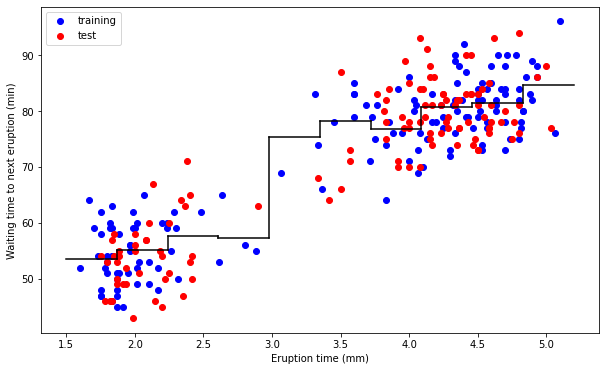

In [7]:
plt.figure(figsize=(10, 6))

plt.scatter(train['eruptions'], train['waiting'], c='b', label='training')
plt.scatter(test['eruptions'], test['waiting'], c='r', label='test')
plt.xlabel("Eruption time (mm)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc='upper left')

for b in range(len(left_borders)):
    plt.plot([left_borders[b], right_borders[b]], [g_hat[b], g_hat[b]], "k-")
for b in range(len(left_borders) - 1):
    plt.plot([right_borders[b], right_borders[b]], [g_hat[b], g_hat[b + 1]], "k-")    

plt.show()

## RMSE of Regressogram

$\textrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N_{test}}{(y_i - \hat{y}_i)^2}}{N_{test}}}$

In [8]:
def calculate_rmse(X_test, y_test, left_borders, right_borders):
    total_error = sum([((y_test[(left_borders[i] < X_test) & (X_test <= right_borders[i])] - g_hat[i])**2).sum()
                       for i in range(len(left_borders))])
    return np.sqrt(total_error / len(X_test))

In [9]:
rmse = calculate_rmse(X_test, y_test, left_borders, right_borders)

In [10]:
print(f"Regressogram => RMSE is {rmse} when h is {bin_width}")

Regressogram => RMSE is 5.962617204275405 when h is 0.37


## Running Mean Smoother

$\hat{g}(x) = \frac{\sum_{t-1}^N{w(\frac{x-x^t}{h})r^t}}{\sum_{t-1}^N{w(\frac{x-x^t}{h})}}$



$
\begin{equation}
  w(u) =
  \begin{cases}
    1 & \text{if |u| < 1} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}
$

In [11]:
bin_width = 0.37
data_interval = np.linspace(minimum_value, maximum_value, 1601)

In [12]:
def w(u):
    if np.abs(u) < 1:
        return 1
    else:
        return 0

In [13]:
g_hat = [(np.asarray([w(u) for u in (x - X_train) / bin_width]) * y_train).sum() / (np.asarray([w(u) for u in (x - X_train) / bin_width])).sum() for x in data_interval]

### Drawing Running Mean Smoother

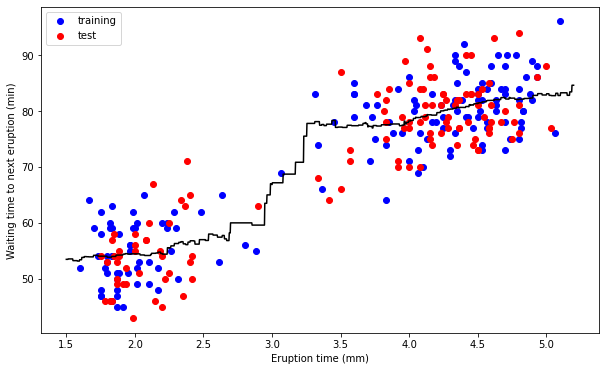

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(train['eruptions'], train['waiting'], c='b', label='training')
plt.scatter(test['eruptions'], test['waiting'], c='r', label='test')
plt.xlabel("Eruption time (mm)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc='upper left')

plt.plot(data_interval, g_hat, "k-")

plt.show()

## RMSE of Running Mean Smoother

$\textrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N_{test}}{(y_i - \hat{y}_i)^2}}{N_{test}}}$

In [15]:
left_borders = data_interval[:-1]
right_borders = data_interval[1:]

In [16]:
rmse = calculate_rmse(X_test, y_test, left_borders, right_borders)

In [17]:
print(f"Running Mean Smoother => RMSE is {rmse} when h is {bin_width}")

Running Mean Smoother => RMSE is 5.9587977786114354 when h is 0.37


## Kernel Smoother

$\hat{g}(x) = \frac{\sum_t{K(\frac{x-x^t}{h})r^t}}{\sum_t{K(\frac{x-x^t}{h})}}$

$K(u) = \frac{1}{\sqrt{2\pi}}\exp{\left[-\frac{u^2}{2}\right]}$

In [18]:
bin_width = 0.37
data_interval = np.linspace(minimum_value, maximum_value, 1601)

In [19]:
def K(u):
    return 1/np.sqrt(2*np.pi) * np.exp(-(u**2)/2)

In [20]:
g_hat = [(np.asarray([K(u) for u in (x - X_train) / bin_width]) * y_train).sum() / (np.asarray([K(u) for u in (x - X_train) / bin_width])).sum() for x in data_interval]

### Drawing Kernel Smoother

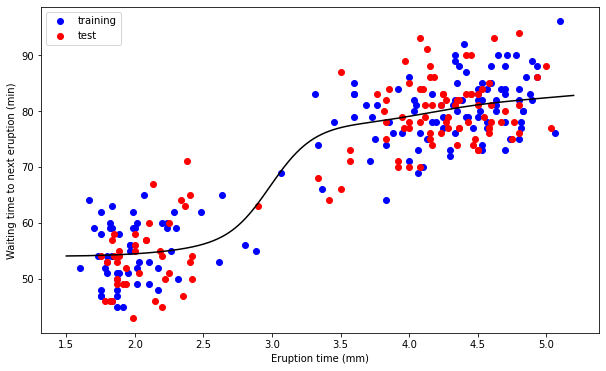

In [21]:
plt.figure(figsize=(10, 6))

plt.scatter(train['eruptions'], train['waiting'], c='b', label='training')
plt.scatter(test['eruptions'], test['waiting'], c='r', label='test')
plt.xlabel("Eruption time (mm)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc='upper left')

plt.plot(data_interval, g_hat, "k-")

plt.show()

## RMSE of Kernel Smoother

$\textrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N_{test}}{(y_i - \hat{y}_i)^2}}{N_{test}}}$

In [22]:
left_borders = data_interval[:-1]
right_borders = data_interval[1:]

In [23]:
rmse = calculate_rmse(X_test, y_test, left_borders, right_borders)

In [24]:
print(f"Kernel Smoother => RMSE is {rmse} when h is {bin_width}")

Kernel Smoother => RMSE is 5.874042666597442 when h is 0.37
